## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'X_RANGE':3, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':100,
    'LEARNING_RATE':5e-2,
    'BATCH_SIZE':128,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [5]:
train_df = pd.read_csv('./train.csv')

In [6]:
train_df.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


## Data Visualization

In [7]:
# def get_view_df(df, target):
#     viewd = df[['일시', target]]
#     viewd = viewd.reset_index(drop=True)
#     viewd = viewd.reset_index()
#     print(target)
#     sns.set(rc = {'figure.figsize':(30,8)})
#     sns.lineplot(x='index', y=target, data=viewd)
#     plt.show()

In [8]:
# get_view_df(train_df, '광진구')
# get_view_df(train_df, '동대문구')
# get_view_df(train_df, '성동구')
# get_view_df(train_df, '중랑구')

## Train / Validation Split

In [9]:
val_df = train_df.iloc[1200-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train_df.iloc[:1200].reset_index().drop(columns='index') # 20180101 ~ 20201231

## Data Pre-processing

In [10]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [11]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [12]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [13]:
train_x, train_y = get_x_y_data(train_df)

  0%|          | 0/1197 [00:00<?, ?it/s]

In [14]:
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/261 [00:00<?, ?it/s]

## CustomDataset

In [15]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [16]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Define Model

In [17]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=7, hidden_size=256, num_layers=4, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

## Train

In [18]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model 
    return best_model

In [19]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss    

## Run!!

In [20]:
model = BaseModel()

In [21]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [2.99632] Val MAE : [6.76315]
Epoch : [2] Train Loss : [2.04574] Val MAE : [3.14109]
Epoch : [3] Train Loss : [1.79960] Val MAE : [2.99969]
Epoch : [4] Train Loss : [1.66782] Val MAE : [3.91091]
Epoch : [5] Train Loss : [1.51504] Val MAE : [2.86789]
Epoch : [6] Train Loss : [1.47468] Val MAE : [5.63417]
Epoch 00006: reducing learning rate of group 0 to 2.5000e-02.
Epoch : [7] Train Loss : [1.19251] Val MAE : [13.17346]
Epoch : [8] Train Loss : [1.14297] Val MAE : [2.67876]
Epoch : [9] Train Loss : [1.17181] Val MAE : [7.12684]
Epoch : [10] Train Loss : [1.13933] Val MAE : [30.28434]
Epoch : [11] Train Loss : [1.30946] Val MAE : [54.92279]
Epoch : [12] Train Loss : [1.23843] Val MAE : [121.97536]
Epoch : [13] Train Loss : [1.17514] Val MAE : [143.29940]
Epoch : [14] Train Loss : [1.13864] Val MAE : [77.27527]
Epoch : [15] Train Loss : [1.16575] Val MAE : [165.71823]
Epoch : [16] Train Loss : [1.14126] Val MAE : [164.48955]
Epoch : [17] Train Loss : [1.14707] Val

## Inference

In [22]:
test_df = pd.read_csv('./sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')

In [23]:
test_df.head()

,년,월,일,광진구,동대문구,성동구,중랑구
0,2.021,1.000000,0.935484,4.490,3.524,3.66,2.524
1,2.021,1.000000,0.967742,4.444,3.574,3.53,2.506
2,2.021,1.000000,1.000000,3.616,3.210,2.62,2.146
3,2.022,0.083333,0.032258,0.000,0.000,0.00,0.000
4,2.022,0.083333,0.064516,0.000,0.000,0.00,0.000


In [24]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['광진구', '동대문구', '성동구', '중랑구']].reset_index().drop(columns=['index'])

In [25]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

## Submission

In [26]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [27]:
submit['광진구'] = preds['광진구']
submit['동대문구'] = preds['동대문구']
submit['성동구'] = preds['성동구']
submit['중랑구'] = preds['중랑구']

<AxesSubplot:>

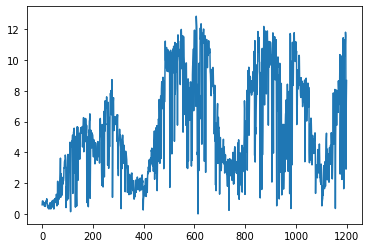

In [28]:
train_df['광진구'].plot()

<AxesSubplot:>

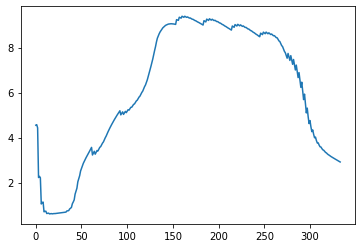

In [29]:
submit['광진구'].plot()

<AxesSubplot:>

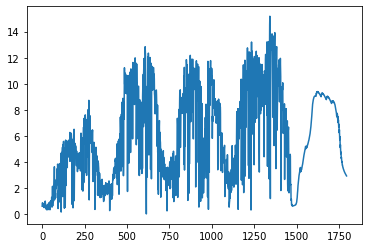

In [30]:
train_df = pd.read_csv('./train.csv')
pd.concat([train_df,submit]).reset_index()['광진구'].plot()

<AxesSubplot:>

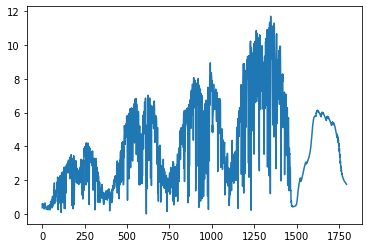

In [31]:
pd.concat([train_df,submit]).reset_index()['동대문구'].plot()

<AxesSubplot:>

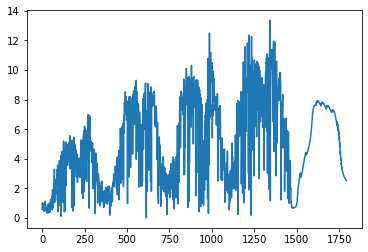

In [32]:
pd.concat([train_df,submit]).reset_index()['성동구'].plot()

<AxesSubplot:>

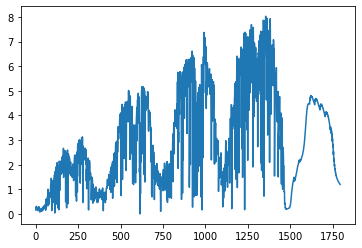

In [33]:
pd.concat([train_df,submit]).reset_index()['중랑구'].plot()

In [34]:
submit.to_csv('./submit.csv', index=False)